Boe Supervision Challenge Report

In [110]:
# Imports
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Data Ingestion

Format dataset and save to a CSV that is ready for data analysis.

In [111]:
# convert excel sheets into dataframe
general_df = pd.read_excel('1_bronze_dataset.xlsx', sheet_name=0)
underwritting_df = pd.read_excel('1_bronze_dataset.xlsx', sheet_name=1)

# Combine the Year End and Metric columns
general_df.columns = general_df.columns + '_' + general_df.iloc[0]
general_df = general_df.drop([0])

underwritting_df.columns = underwritting_df.columns + '_' + underwritting_df.iloc[0]
underwritting_df = underwritting_df.drop([0])

# Rename first column to "Firm Name"
general_df.columns.values[0] = 'Firm Name'
underwritting_df.columns.values[0] = 'Firm Name'

# Merge the two dataframes
df = general_df.merge(underwritting_df, left_on='Firm Name', right_on='Firm Name', how='outer')

# Melt dataframe
df = pd.melt(df, id_vars=['Firm Name'], var_name='Metric', value_name='Value')

# Remove unwanted characters from Atribute
df['Metric'] = df['Metric'].str.replace('.1', '')
df['Metric'] = df['Metric'].str.replace('.2', '')
df['Metric'] = df['Metric'].str.replace('.3', '')
df['Metric'] = df['Metric'].str.replace('.4', '')

# Split Year End values from Metrics into different columns
df[['Metric', 'Year End']] = df['Metric'].str.split('_', expand=True)

# Remove "YE" from Year End values
df['Year End'] = df['Year End'].str.replace('YE', '')

# Unmelt dataframe
df = pd.pivot_table(df, values = 'Value', index=['Firm Name','Year End'], columns = 'Metric').reset_index()

# Remove index column name
df = df.rename_axis(None, axis=1)

# Save dataframe as CSV
df.to_csv('2_silver_dataset.csv', encoding='utf-8', index=False)
display(df.head())

,Firm Name,Year End,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)",Gross claims incurred (£m),Gross combined ratio,Gross expense ratio,NWP (£m),"Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Net combined ratio,Net expense ratio,Pure gross claims ratio,Pure net claims ratio,SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m)
0,Firm 1,2016,2416.559785,1243.924991,46.76803,0.0,0.0,0.0,0.0,-17754.100486,0.0,0.0,0.0,0.0,0.0,2021.321862,0.16252,63676.869102,40171.683156
1,Firm 1,2017,3.796177,4.398725,0.0,0.588994,0.005515,0.675051,77.251254,0.0,9.894597,71.298841,41.01306,17.534691,17.184308,0.0,55887003.057573,9.566096,0.0
2,Firm 1,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Firm 1,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Firm 1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Cleaning

The data is pretty clean
- replace 0s with Nan#=
- remove outliers

In [112]:
df = pd.read_csv('2_silver_dataset.csv')

# Replace all zeros with NaN given that is unlikely a zero is the real value of those metrics
df.replace(0, np.nan, inplace=True)

# Configure data type to String so that it is not mistaken for a numeric column
df['Firm Name'] = df['Firm Name'].astype(str)
df['Year End'] = df['Year End'].astype(str)

# List numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Check outlier by looking at distribution of data
display(df.describe())

# Can be printed for a clearer view
# for column in numeric_cols:   
#     sns.boxplot(data=df, x='Year End', y=column)
#     plt.show()

,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)",Gross claims incurred (£m),Gross combined ratio,Gross expense ratio,NWP (£m),"Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Net combined ratio,Net expense ratio,Pure gross claims ratio,Pure net claims ratio,SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m)
count,1360.000000,1365.000000,1110.000000,1449.000000,1417.000000,1.267000e+03,1265.000000,1073.000000,1435.000000,1.235000e+03,1.234000e+03,1253.000000,1221.000000,1.359000e+03,1.358000e+03,1364.000000,1355.000000
mean,602.320736,641.794281,1371.287668,448.628978,206.574955,3.139600e+03,445.571393,1108.204771,288.159815,-4.437976e+03,-1.461708e+03,769.253769,652.046551,4.144828e+02,1.470283e+06,8631.151973,8491.140310
std,2461.050616,2358.409069,5704.712983,1234.497871,532.333959,1.117672e+05,16178.686443,4842.220929,784.396169,1.556336e+05,1.492040e+05,27836.806128,23739.560243,1.708682e+03,3.700454e+07,36362.182210,36555.223494
min,-162.245016,-123.609578,-19.777480,-167.815824,-189.936333,-1.406448e+04,-16112.406623,-17754.100486,-182.381851,-5.468706e+06,-4.495420e+06,-24817.785823,-33721.020240,1.867646e-09,-3.488211e+00,-207.356238,-1487.107764
25%,10.250982,11.112292,7.070893,7.065466,2.191648,3.521795e-01,0.139755,3.902015,3.023404,3.927756e-01,1.515120e-01,0.198470,0.171981,3.908801e+00,9.203866e-01,27.223696,11.765754
50%,47.544842,48.425189,58.437224,68.630510,32.608981,8.649898e-01,0.302267,35.960668,37.358641,9.142253e-01,3.672417e-01,0.521793,0.481683,2.311497e+01,1.988065e+00,167.078648,95.952245
75%,233.210803,230.108922,424.251489,336.425819,169.773552,1.436066e+00,0.515924,302.760593,217.798775,1.505411e+00,6.287726e-01,0.944852,0.883788,1.278356e+02,3.485000e+00,1336.916774,997.358345
max,41636.299252,26705.042053,74078.635849,19292.066525,6844.014131,3.978266e+06,575064.786983,75526.673293,11351.609021,4.318219e+04,2.691212e+06,985011.303759,828809.371523,2.278836e+04,9.993029e+08,553549.903858,494498.525611


Findings:

Several columns exhibited pronounced outliers in the dataset:

- Gross Combination Ratio
- Gross Expense Ratio
- Net Combination Ratio
- Net Expense Ratio
- Pure Gross Claims Ratio
- Pure Net Claims Ratio
- SCR Coverage Ratio

Additionally, the data distribution for all these columns appeared to be skewed, predominantly to the right. This skewness is typical in the insurance industry, where a few large players coexist with numerous smaller ones.

Given the skewed distribution, I will employ the interquartile range to detect outliers.

Recognizing the challenge of distinguishing outliers and the need to identify large and high-risk firms for supervision, I will adopt a conservative approach and set a very high upper limit.

In [113]:
# Calculate quantiles and IQR
Q1 = df[numeric_cols].quantile(0.25) 
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Setting upper and lower limit
upper_limit = Q3 + 10 * IQR
lower_limit = Q1 - 3 * IQR

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((df[numeric_cols] < (lower_limit)) | (df[numeric_cols] > (upper_limit))).any(axis=1)

# Create a dataframe of rows which fall outside limits
df_outside_limit = df[~condition]

# Update conditions for firms which have have more than two or more rows outside limit:
for i, firm_names in df_outside_limit['Firm Name'].items():
    if len(df_outside_limit[df_outside_limit['Firm Name'] == firm_names]) > 1:
        condition[i]=True

# Update conditions for rows which stil exhibit extreme outliers
# New upper limit
new_upper_limit = Q3 + 50 * IQR
new_lower_limit = Q1 - 3 * IQR

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((df[numeric_cols] < (new_lower_limit)) | (df[numeric_cols] > (new_upper_limit))).any(axis=1)

# Filter our dataframe based on condition
df_no_outlier = df[condition]

# Save cleaned dataset to csv file
df_no_outlier.to_csv('3_gold_dataset.csv', encoding='utf-8', index=False)

I've visualised the clean dataset in the dashbaord below, you can view the new distribution of each Metric by selecting the Metric on the dropdown.

The outliers are no longer visible

In [114]:
%%HTML
<div class='tableauPlaceholder' id='viz1701026923696' style='position: relative'><noscript><a href='#'><img alt='BoE Supervision Challenge ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;BoESupervisionChallenge-NewDistribution&#47;DistributionDashboard&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='BoESupervisionChallenge-NewDistribution&#47;DistributionDashboard' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;BoESupervisionChallenge-NewDistribution&#47;DistributionDashboard&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1701026923696');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else { vizElement.style.width='100%';vizElement.style.height='727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

# Data Exploration:

Before exploring the dataset, I spent time understanding the meaning of all the metrics provided. Although each metric offers unique insights into the performance of insurance firms, there are overlaps in how they indicate the size, riskiness, and profitability of a firm.

To provide the analysis with greater direction and focus, I gave special consideration to Gross Written Premiums (GWP), a key indicator of size, and the Solvency Capital Requirement (SCR) Coverage Ratio, a pivotal metric indicating risk.

In [115]:
%%HTML
<div class='tableauPlaceholder' id='viz1701028335372' style='position: relative'><noscript><a href='#'><img alt='Story 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;BoESupervisionChallenge-AnalysisReport&#47;Story1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='BoESupervisionChallenge-AnalysisReport&#47;Story1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;BoESupervisionChallenge-AnalysisReport&#47;Story1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1701028335372');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1016px';vizElement.style.height='991px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>


## Tableau Visuals Page 1

Initially, I hypothesized a landscape in the insurance sector with a few major players and numerous smaller ones. To investigate the size distribution, I utilized Gross Written Premiums (GWP) and found that the hypothesis was largely accurate, as revealed in the Tableau Visuals (page 1).

Subsequently, I delved into examining the correlation between firm size (measured by GWP) and each metric. As anticipated, there was a distinct correlation with Total Assets, Total Liabilities, and Net Written Premiums (NWP).

However, there were no evident correlations between the size (GWP) and other metrics indicative of risk and profitability.

## Tableau Visuals Page 2

Given the logical emphasis on larger and riskier firms, I aimed to visually assess the latest (Year 2020) distribution of companies concerning Size and Risk, which you will see in the Tableau Visuals (page 2)

In pursuit of this perspective, I grouped the data into four groups which you can differtation through the different colours on the dashboard:

- Big and Risky (SCR < 1 and GWP > £500M)
- Big (SCR >=1 and GWP > £500M)
- Small and Risky (SCR < 1 and GWP < £500M)
- Neutral

You can also see the count of firms in each group at the bottom of the dashboard.

To determine which firms to supervise, we can begin with a straightforward benchmark, prioritizing "Big and Risk," followed by "Small and Risky," and then "Big."

## Tableau Visuals Page 3


Having established a benchmark, I further investigated potential relationships between these groups and other metrics. However, no distinct relationships were identified between these groups and the remaining metrics.

## Tableau Visuals Page 4

Now that we have highlighted categories, we can turn our attention to additional metrics and identify specific firms that warrant attention on our radar, as depicted in the last dashboard.

# Data Clustering

I decide to use K-means clustering to find patterns in the dataset to see if we can identify natural groupings or clusters of within similarities, In the context of insurance firms, this method would allow us to group firms which can provide valuable insights for determining which firms to supervise.
By applying K-means clustering to insurance firm data, I hoped to discover patterns or groupings related to size, riskiness, profitability, or other relevant factors.

In [116]:
# Load your dataset
df = pd.read_csv('3_gold_dataset.csv')

# filter by year
df = df[df['Year End'] == 2020]

# Select the relevant metrics for clustering
metrics = df.select_dtypes(include=[np.number]).columns

# Extract the selected metrics
data = df[metrics]

# Handle missing values
data.fillna(data.mean(), inplace=True) 

# Standardize the data (important for K-means)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Choose the number of clusters (you may need to experiment with this)
num_clusters = 4

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=3)
df['cluster'] = kmeans.fit_predict(scaled_data)

# Compare metrics by cluster
display(df.groupby('cluster')[numeric_cols].mean())



C:\Users\Daddy\AppData\Local\Temp\ipykernel_5680\4070319042.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(data.mean(), inplace=True)
c:\Users\Daddy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)",Gross claims incurred (£m),Gross combined ratio,Gross expense ratio,NWP (£m),"Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Net combined ratio,Net expense ratio,Pure gross claims ratio,Pure net claims ratio,SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m)
cluster,,,,,,,,,,,,,,,,,
0,871.641059,1165.805932,3263.128422,284.668669,290.159108,1.008872,0.295145,3656.001383,209.779979,0.787603,0.283517,0.613801,0.391092,891.120315,1.705647,17208.863737,18298.672132
1,10287.309499,8279.521225,365.441556,NaN,NaN,NaN,NaN,1396.297028,NaN,NaN,NaN,NaN,NaN,4143.092997,3.278201,16320.072011,2225.159382
2,208.326726,209.384957,321.875003,2450.765637,1342.565775,1.122665,0.361888,103.072847,2102.112770,1.036765,0.334615,0.658279,0.660011,108.824077,2.776726,765.391450,679.290253
3,128.913425,149.090729,206.383839,245.693634,99.815070,1.039689,0.394288,153.925601,150.299413,1.109548,0.517355,0.660022,0.579491,74.451959,3.766713,828.723684,708.692600


Based on my K-means clustering findings, I've identified distinct characteristics for each cluster. Here's a summarized overview:

Cluster 0: Large Insurance Companies
- Characteristics: High values in Gross Written Premium (GWP), Total Assets, and Liabilities.
- Interpretation: Represents insurance companies that are considered large based on various financial indicators.

Cluster 1: High Equity with Limited Data Submission
- Characteristics: Relatively lower data submission but stands out with very high equity.
- Interpretation: Indicates firms with substantial equity, even though they may not have submitted as much data as other clusters.

Cluster 2: High Liabilities despite Moderate Size
- Characteristics: High Gross Best Estimate Liability (BEL), Net BEL, and gross claims. However, the Gross Written Premium (GWP) suggests a moderate size.
- Interpretation: Suggests companies with significant liabilities relative to their size in terms of GWP, warranting attention due to the potential risk associated with large liabilities.

Cluster 3: Moderate Characteristics
- Characteristics: Does not stand out significantly compared to the other clusters.
- Interpretation: Represents a group that does not exhibit extreme values in the observed features.
Supervision Focus:

Considering my findings, I propose focusing on Cluster 0 and Cluster 2 for supervision due to their distinct characteristics. Cluster 0 with its large size are firms which could contribute to systemic risk, and Cluster 2, despite moderate size, has significant liabilities that could pose a risk. This targeted approach should allow for a more efficient allocation of resources in terms of monitoring and supervision.

I found it intriguing to juxtapose the outcomes of the K-means clustering with the predefined groupings I established in Tableau based on specific criteria:

- Big and Risky: Entities with a Solvency Capital Requirement (SCR) below 1 and Gross Written Premium (GWP) exceeding £500 million.
- Big: Entities with an SCR equal to or greater than 1 and GWP surpassing £500 million.
- Small and Risky: Entities with an SCR below 1 and GWP less than £500 million.
- Neutral: Entities falling outside the criteria of the above groups.

To explore this comparison, I visualized the data on a chart plotting GWP against the SCR coverage ratio.

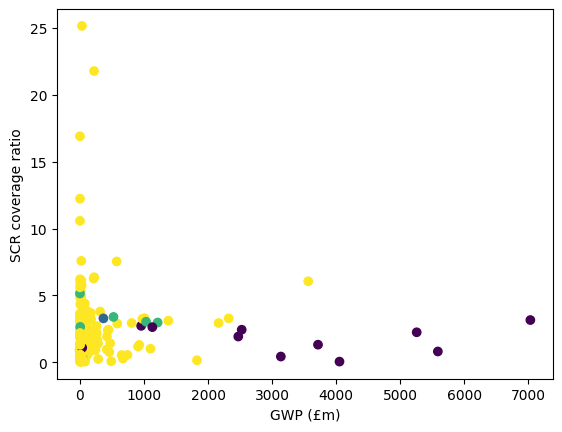

In [117]:
# Compare clustering findings with Tableau Groups that I created 
plt.scatter(df['GWP (£m)'], df['SCR coverage ratio'], c=df['cluster'])

plt.xlabel('GWP (£m)')
plt.ylabel('SCR coverage ratio')
plt.show()

Based on the chart, it appears that our classifications align effectively for the "Big" firms category. However, there is a degree of ambiguity in delineating the other categories.